In [1]:
import numpy as np
from matplotlib.pyplot import *

In [2]:
run_params = {}
run_params['snr'] = 10.0
run_params['ldist'] = 10.0
run_params['object_redshift'] = 3.548
run_params['fixed_metallicity'] = None
run_params['add_duste'] = True
run_params['zcontinuous'] = 1
# run_params

In [3]:
def getObs(snr=10, ldist=10.0, **extras_):

    from prospect.utils.obsutils import fix_obs
    import sedpy
#     import numpy as np

    # obs is a dictionary of observational data to use for the fit
    obs = {}

    filternames = ['jwst_f090w', 'jwst_f115w', 'jwst_f150w', 'jwst_f200w', 'jwst_f277w',
                   'jwst_f356w', 'jwst_f410m', 'jwst_f444w', 'jwst_f770w', 'jwst_f1800w']
    obs['filters'] = sedpy.observate.load_filters(filternames)

    ################################################# FIX THE UNITS OF THIS DATA
    M_AB = np.array([0.0148, 0.028, 0.0269, 0.322, 1.090, 1.334, 1.597, 1.725, 1.54, 1.96]) # These are currently in units of microJanskeys (fix)
    ################################################# FIX THE UNITS OF THIS DATA

#     # jansky_to_maggie_factor = 3631.0

#     dm = 25 + 5.0 * np.log10(ldist)
#     mags = M_AB + dm

    obs['maggies'] = 10**(-0.4*M_AB)
    obs['maggies_unc'] = (1./snr) * obs['maggies']

    obs['phot_wave'] = np.array([f.wave_effective for f in obs['filters']])

    obs['wavelength'] = None
    obs['spectrum'] = None
    obs['unc'] = None
    obs['mask'] = None

    obs = fix_obs(obs)
    
    return obs

In [4]:
obs = getObs(**run_params)

In [7]:
def getModel(object_redshift=None, ldist=10.0, fixed_metallicity=None, add_duste=False, **extras):
    """Build a prospect.models.SedModel object
    
    :param object_redshift: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate
        for this redshift. Otherwise, the redshift will be zero.
        
    :param ldist: (optional, default: 10)
        The luminosity distance (in Mpc) for the model. Spectra and observed
        frame (apparent) photometry will be appropriate for this luminosity distance.
        
    :param fixed_metallicity: (optional, default: None)
        If given, fix the model metallicity  (:math: `log(Z/Z_sun)`) to the given value.
        
    :param add_duste: (optional, default: False)
        If `True`, add dust emission and associated (fixed) parameters to the model.
        # 
    :returns model:
        An instance of prospect.models.SedModel    
    """
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors
    
    # Get (a copy of) one of the prepackaged model set dicitonaries.
    # This is, somewhat confusingly, a dictionary of dictionaries, keyed by a parameter name.
    model_params = TemplateLibrary['parametric_sfh']
    
    # Now add the lumdist parameter by hand as another entry in the dictionary.
    # This will control the distance since we are setting the redshift to zero.
    # In `build_obs` above we used a distance of 10Mpc to convert from absolute to apparent magnitudes,
    # so we use that here too, since the `maggies` are appropriate for that distance.
    model_params['lumdist'] = {'N': 1, 'isfree': False, 'init': ldist, 'units': 'Mpc'}
    
    # Let's make some changes to the initial values appropriate for our objects and data
    model_params['zred']['init'] = 0.0
    model_params['dust2']['init'] = 0.05
    model_params['logzsol']['init'] = -0.5
    model_params['tage']['init'] = 13.
    model_params['mass']['init'] = 1e8
    
    # These are dwarf galaxies, so let's also adjust the metallicity prior,
    # the tau parameter upward, and the mass prior downward.
    
    model_params['mass']['isfree'] = False
    model_params['tage']['isfree'] = False
    model_params['tau']['isfree'] = False
    model_params['dust2']['isfree'] = False
    model_params['logzsol']['isfree'] = False
    
    # Change the model parameter specifications based on some keyword arguments
    if fixed_metallicity is not None:
        model_params['logzsol']['init'] = fixed_metallicity
        
    if object_redshift is not None:
        model_params['zred']['init'] = object_redshift
        
    if add_duste:
        # Add dust emission (with fixed dust SED parameters)
        # Since `model_params` is a dictionary of parameter specifications,
        # and `TemplateLibrary` returns dictionaries of parameter specifications,
        # we can just update `model_params` with the parameters described in the
        # pre-packaged `dust_emission` parameter set.
        model_params.update(TemplateLibrary['dust_emission'])
        
    # Now instantiate the model object using this dictionary of parameter specifications.
    model = SedModel(model_params)
    
    return model

In [8]:
model = getModel(**run_params)

In [9]:
def getSps(zcontinuous=1, **extras):
    """
    :param zcontinuous:
        A value of 1 ensures that we use interpolation between SSPs to
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details
    """
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

In [10]:
sps = getSps(**run_params)

In [11]:
# model.fixed_params

['zred',
 'mass',
 'logzsol',
 'dust2',
 'sfh',
 'tage',
 'imf_type',
 'dust_type',
 'tau',
 'lumdist',
 'add_dust_emission',
 'duste_umin',
 'duste_qpah',
 'duste_gamma']

In [ ]:
theta = model.theta.copy()

In [ ]:
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)

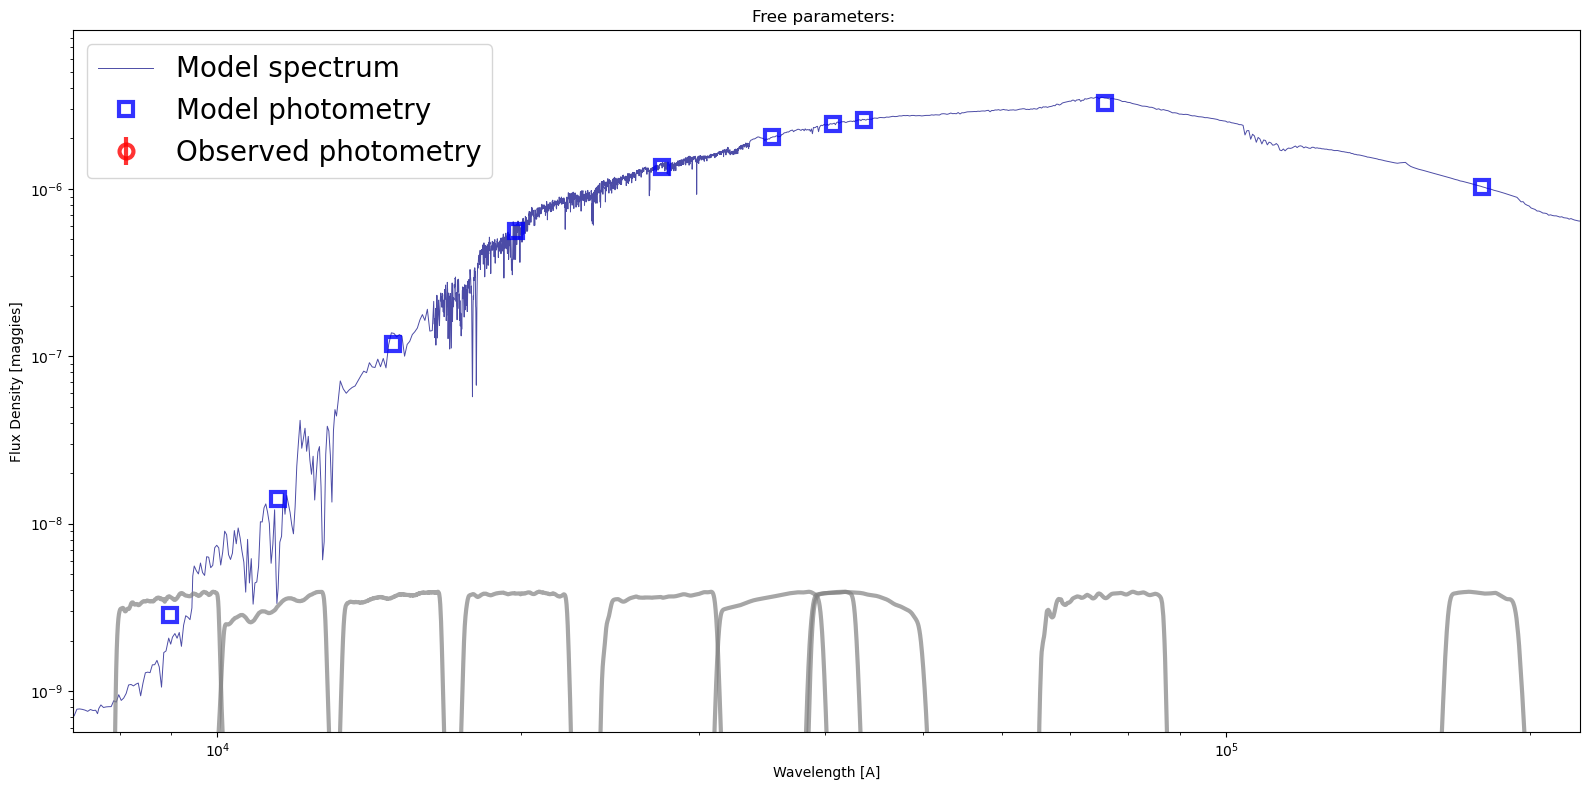

In [13]:
title_text = 'Free parameters: '+','.join(["{}={}".format(p, model.params[p][0])
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # Cosmological redshifting
# Photometric effective wavelengths
wphot = obs['phot_wave']
# Spectroscopic wavelengths
if obs['wavelength'] is None:
    # *restframe* spectral wavelengths, since obs['wavelength'] is None
    wspec = sps.wavelengths
    wspec *= a # redshift them
else:
    wspec = obs['wavelength']
    
# Establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# Plot model + data
loglog(wspec, initial_spec, label='Model spectrum',
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue',
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', marker='o',
         markersize=10, alpha=0.8, ls='', lw=3, ecolor='red',
         markerfacecolor='none', markeredgecolor='red',
         markeredgewidth=3)
title(title_text)

# Plot filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
    
# Prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

show()